In [1]:
import pandas as pd
# from crim_intervals.funcs import *
from intervals.main_objs import *
from intervals.main import *

from ipywidgets import interact
import re

music21: Certain music21 functions might need the optional package matplotlib;
                  if you run into errors, install it by following the instructions at
                  http://mit.edu/music21/doc/installing/installAdditional.html


In [2]:
def map_colours(x, rest_colour="#fbb4ae", empty_colour="white", remainder_colour="#ccebc5"):
    if x == "Rest":
        return f"background: {rest_colour}"
    elif pd.isnull(x) or (not x) or (x == "-"):
        return f"background: {empty_colour}"
    else:
        return f"background: {remainder_colour}"
    
    
def add_offset(s, lyric_line=3):
    for n in s.recurse().getElementsByClass('Note'):
        n.addLyric(int(n.getOffsetBySite(s.flat.notes)), lyric_line)

In [3]:
piece = "https://crimproject.org/mei/CRIM_Model_0008.mei"

In [4]:
piece

'https://crimproject.org/mei/CRIM_Model_0008.mei'

In [5]:
corpus = CorpusBase([piece])

Requesting file from https://crimproject.org/mei/CRIM_Model_0008.mei...
Successfully imported.


In [6]:
ave_maria = corpus.scores[0]

In [7]:
ave_maria.score.metadata.title

'Ave Maria'

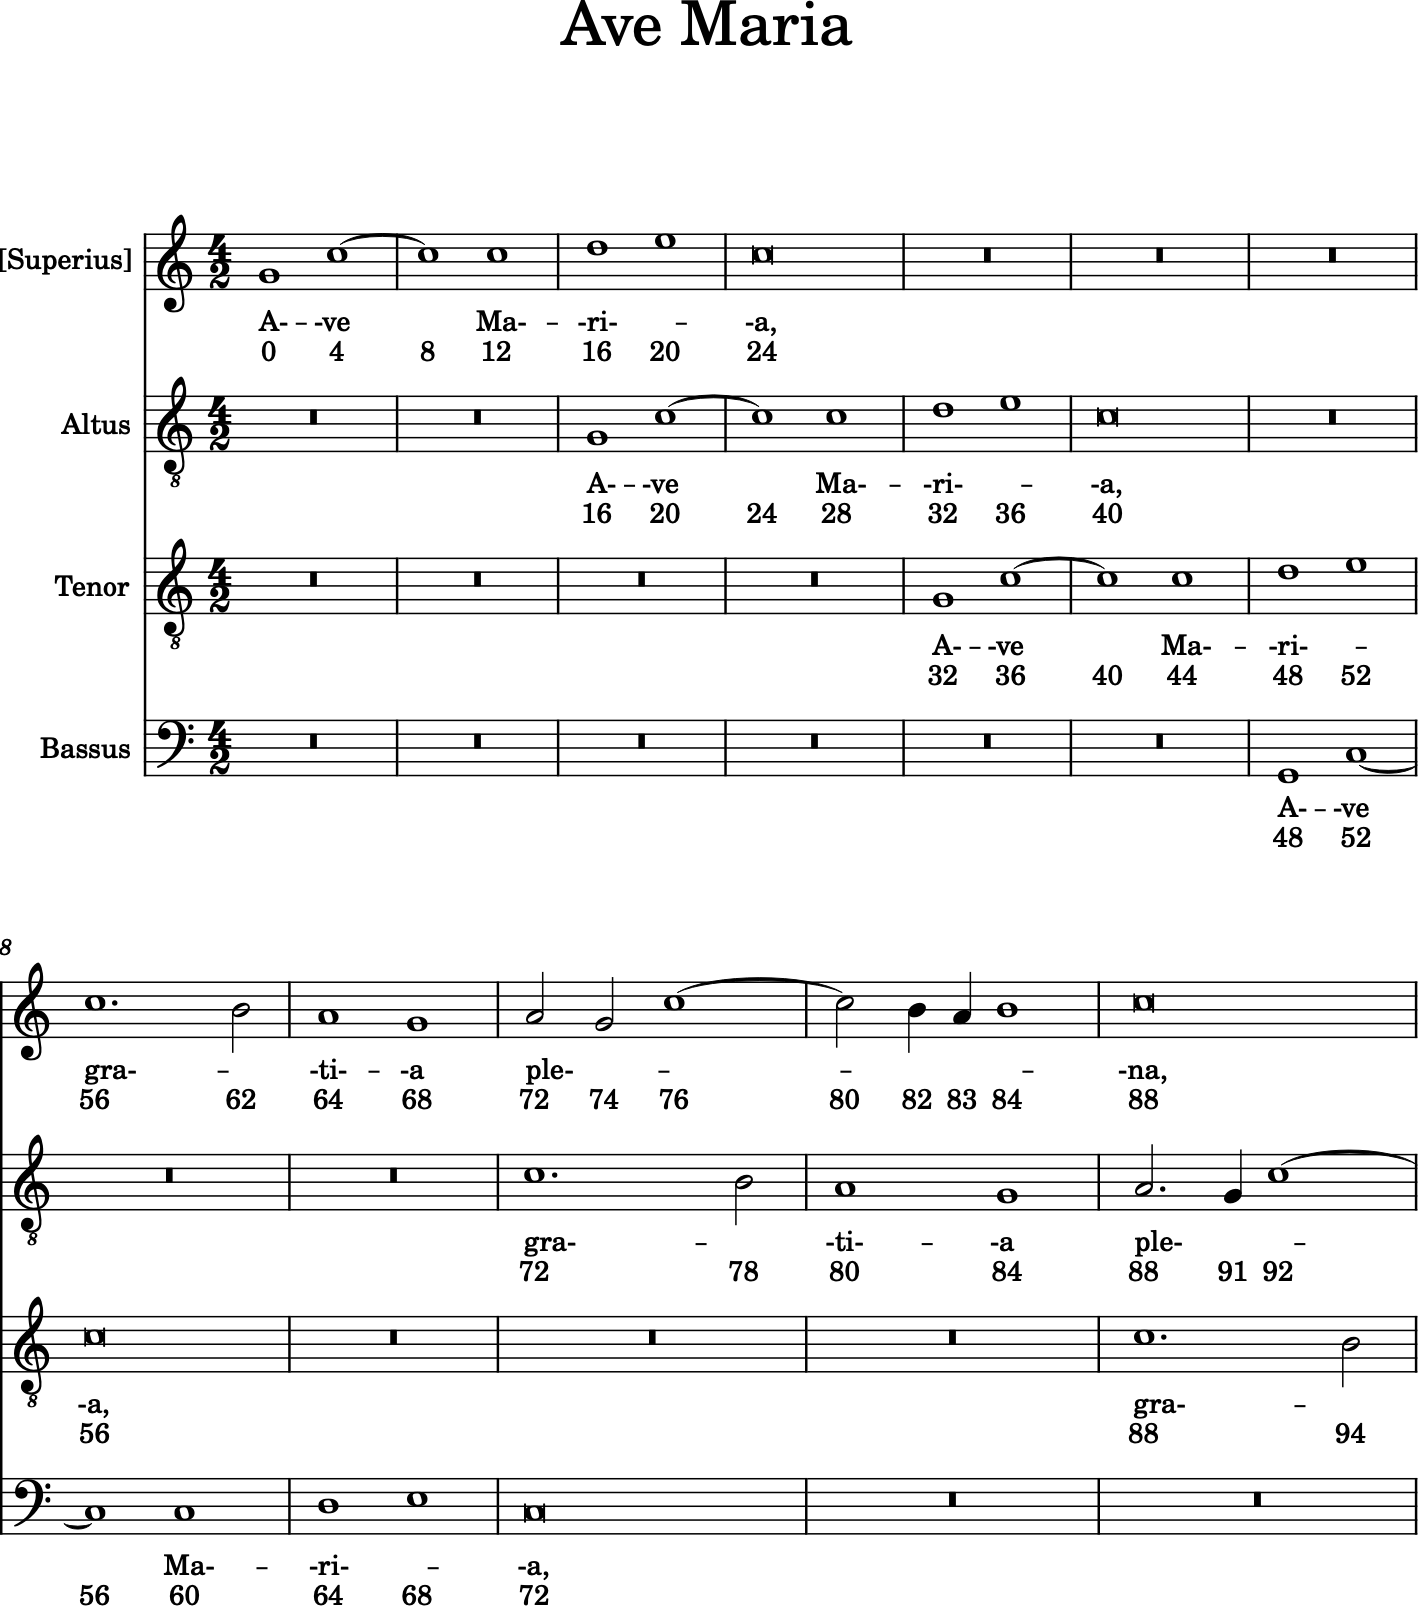

In [11]:
add_offset(ave_maria.score)
ave_maria.score.measures(1, 15).show()

# Music as a table

In [16]:
ave_maria.getNoteRest().head(10).fillna("-").T.style.applymap(map_colours)

,0.0,4.0,8.0,12.0,16.0,20.0,24.0,28.0,32.0,36.0
[Superius],G4,C5,-,C5,D5,E5,C5,-,Rest,-
Altus,Rest,-,Rest,-,G3,C4,-,C4,D4,E4
Tenor,Rest,-,Rest,-,Rest,-,Rest,-,G3,C4
Bassus,Rest,-,Rest,-,Rest,-,Rest,-,Rest,-


# Melodic patterns

In [27]:
ave_melodic = ave_maria.getMelodic(kind="d", unit=2)
# ave_melodic

In [33]:
ngrams = ave_maria.getNgrams(df=ave_maria.getMelodic(kind="d", compound=True), n=5)
ngrams

,[Superius],Altus,Tenor,Bassus
4.0,"4, 1, 2, 2, -3",NaN,NaN,NaN
20.0,NaN,"4, 1, 2, 2, -3",NaN,NaN
36.0,NaN,NaN,"4, 1, 2, 2, -3",NaN
52.0,NaN,NaN,NaN,"4, 1, 2, 2, -3"
62.0,"-2, -2, -2, 2, -2",NaN,NaN,NaN
...,...,...,...,...
1208.0,NaN,NaN,"-2, 1, -2, 2, 2","5, 1, -2, -2, -2"
1212.0,NaN,NaN,NaN,"1, -2, -2, -2, -2"
1236.0,"1, -2, -2, -2, 2","1, 1, -3, 2, 2",NaN,NaN
1240.0,"-2, -2, -2, 2, 1","1, -3, 2, 2, 1","1, -2, 2, 2, -2","8, -4, 2, -2, -5"


Example search: 4, 1, 2, 2 or chromatic 5, 0, 2, 2, -4

In [35]:
@interact(search_pattern="", kind=["d", "c"])
def get_ngrams(search_pattern, kind):
    ngrams = ave_maria.getNgrams(df=ave_maria.getMelodic(kind=kind), n=5)
    mask = ngrams.apply(lambda x: x.astype(str).str.contains(search_pattern).any(), axis=1)
    filtered_ngrams = ngrams[mask].copy()
    return filtered_ngrams.fillna("-").style.applymap(lambda x: "background: #ccebc5" if search_pattern in x else "")

interactive(children=(Text(value='', description='search_pattern'), Dropdown(description='kind', options=('d',…

In [46]:
# TEST
@interact(search_pattern="", kind=["d", "c"], time_unit=[1, 2, 4, 8], length=[3, 4, 5, 6, 7])
def get_ngrams(search_pattern, kind, time_unit, length):
    ngrams = ave_maria.getNgrams(df=ave_maria.getMelodic(kind=kind, unit=time_unit), n=length)
    mask = ngrams.apply(lambda x: x.astype(str).str.contains(search_pattern).any(), axis=1)
    filtered_ngrams = ngrams[mask].copy()
    return filtered_ngrams.fillna("-").style.applymap(lambda x: "background: #ccebc5" if search_pattern in x else "")

interactive(children=(Text(value='', description='search_pattern'), Dropdown(description='kind', options=('d',…

# Count of melodic intervals

In [88]:
ave_maria.getMelodic(directed=True).apply(pd.Series.value_counts).fillna(0).astype(int).style.bar()

,[Superius],Altus,Tenor,Bassus
-M2,54,75,54,38
-M3,8,6,9,12
-P4,0,2,0,3
-P5,0,6,0,9
-P8,0,2,0,0
-m2,29,29,24,19
-m3,8,16,12,11
M2,44,53,45,46
M3,0,3,1,2
M6,0,1,0,0


# Harmonic intervals

Example search pattern: 12, 10, 8, 8|5, 3, 1, 1$

In [87]:
# note that time_unit does not yet work with getHarmonic
@interact(search_pattern="", compound=[True, False], kind=["d", "c"], time_unit=[1, 2, 4, 8], length=[3, 4, 5, 6, 7])
def get_harmonic_ngrams(search_pattern, compound, kind, time_unit, length):    
    ave_harmonic = ave_maria.getHarmonic(kind=kind, compound=compound)
    ngrams = ave_maria.getNgrams(df=ave_harmonic, n=length, cell_type="str", unit=time_unit)
    filtered_ngrams = ngrams[ngrams.apply(lambda x: x.astype(str).str.contains(search_pattern).any(), axis=1)].copy()
    return filtered_ngrams.fillna("-").style.applymap(lambda x: "background: #ccebc5" if re.match(search_pattern, x) else "")


interactive(children=(Text(value='', description='search_pattern'), Dropdown(description='compound', options=(…

## Return offsets as list
### For use with filtered DFs from classifier, etc.

In [80]:
df = get_harmonic_ngrams("7, 6, 8", True, "d", 1, 3)
a = df.index.tolist()
a
for i in a:
    b = i/8 - 1
    print(b)

27.5
32.5
36.5
50.5
57.0
57.5
62.0
62.5
74.5
90.5
136.875
146.375


# Modules:

* Authentic cadence with suspension:  7_Held, 6_-2, 8

In [86]:
@interact(search_pattern="", compound=[True, False], time_unit=[4, 2, 1, 8], length=[3, 4, 5, 6])
def get_modules(search_pattern, compound, time_unit, length):
    
    ave_modules = ave_maria.getHarmonic(kind="d", compound=compound)
    ngrams = ave_maria.getNgrams(df=ave_modules, n=length, how='modules', exclude=['Rest'], cell_type="str", unit=time_unit)
    filtered_ngrams = ngrams[ngrams.apply(lambda x: x.astype(str).str.contains(search_pattern).any(), axis=1)].copy()
    return filtered_ngrams.fillna("-").style.applymap(lambda x: "background: #ccebc5" if re.match(search_pattern, x) else "")

interactive(children=(Text(value='', description='search_pattern'), Dropdown(description='compound', options=(…

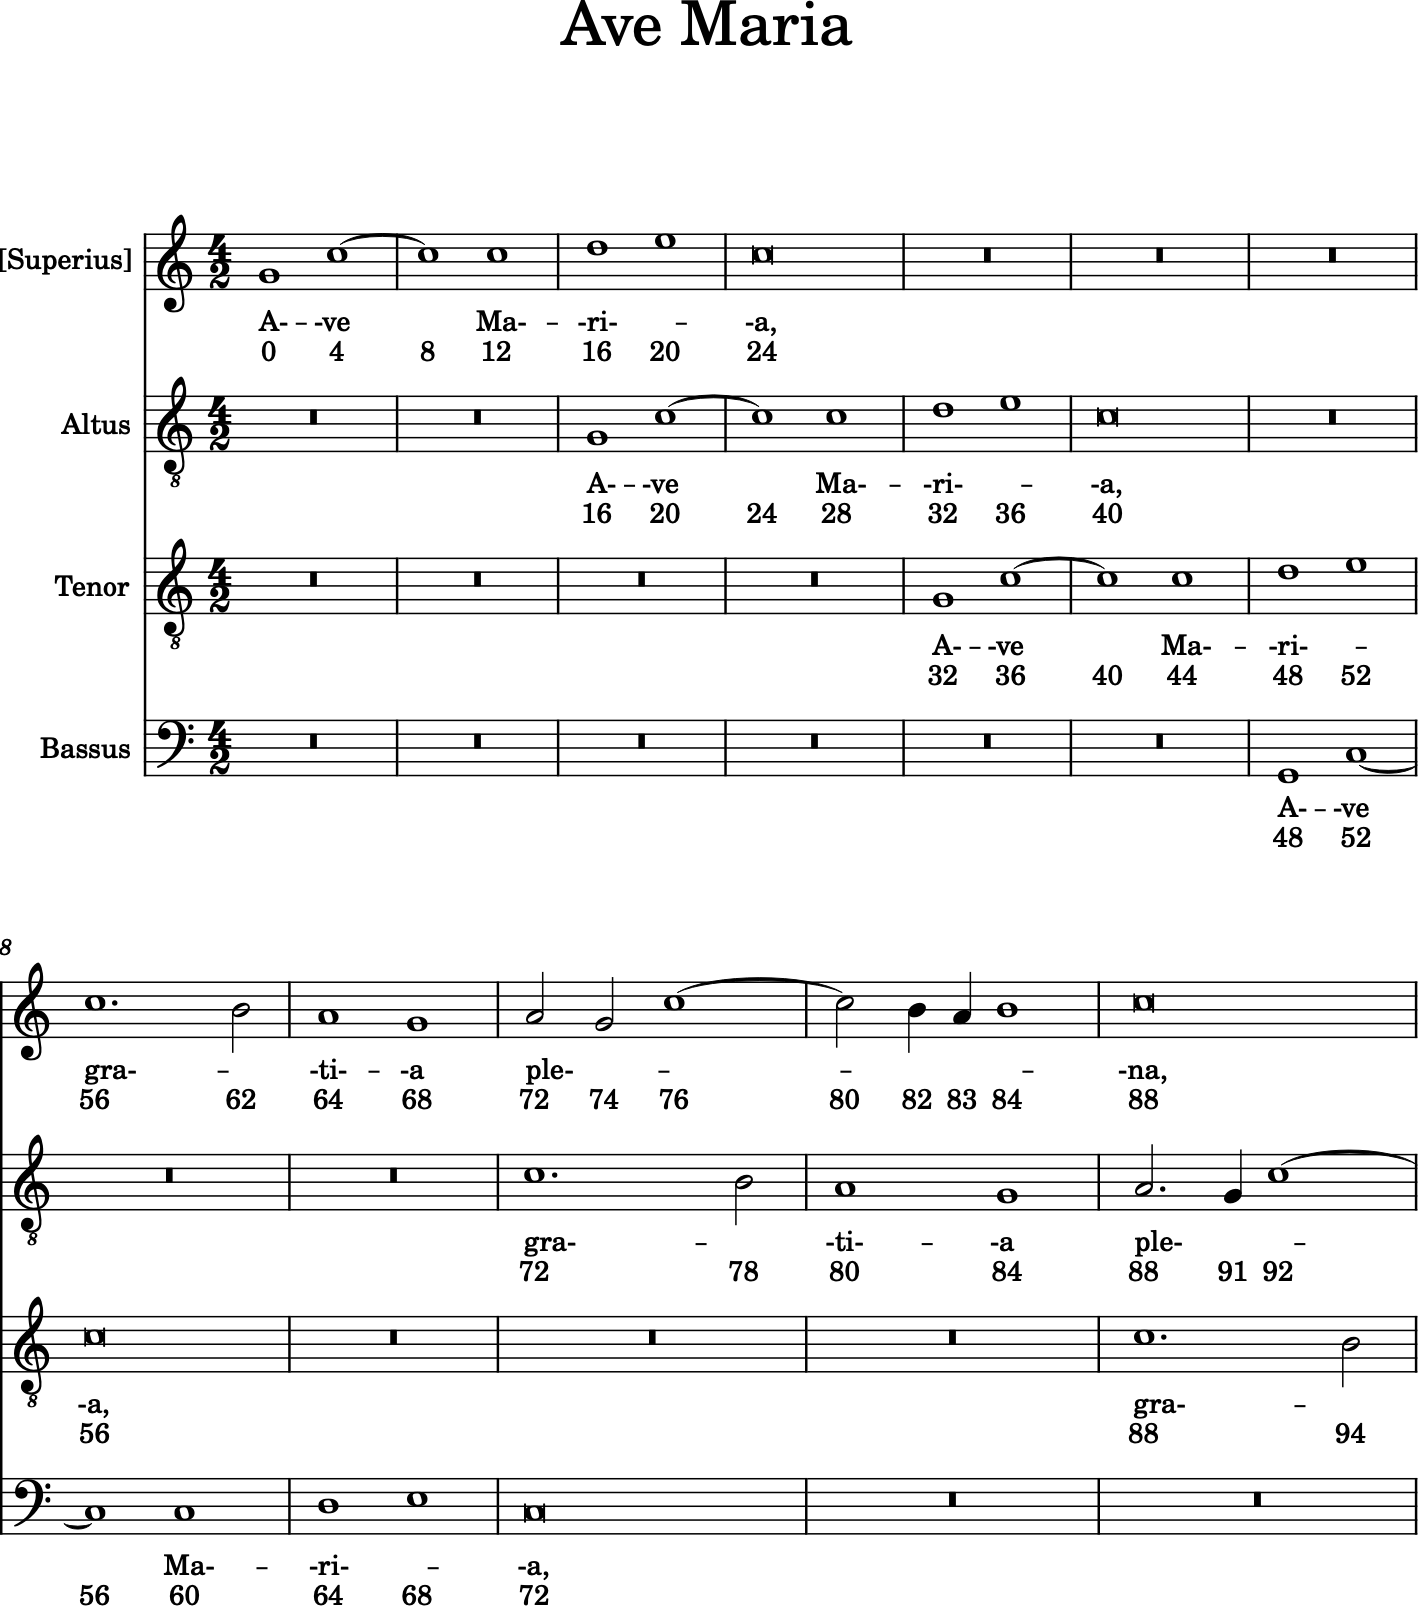

In [57]:
ave_maria.score.measures(1, 200).show()